This notebook entails the steps taken in analyzing an emailing campaign

Import required libraries

In [9]:
import os;

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score


set working directory

In [10]:
os.chdir('~/marketing analysis')

Import all datasets

In [11]:
email_table = pd.read_csv('email_table.csv')
email_opened_table = pd.read_csv('email_opened_table.csv')
link_clicked_table = pd.read_csv('link_clicked_table.csv')

check if email ids are unique

In [12]:
print("No of rows of email_table: " + str(len(email_table)) + ", No of unique emails in email_table: " + str(email_table['email_id'].nunique()))
print("No of rows of email_opened_table: " + str(len(email_opened_table)) + ", No of unique emails in email_opened_table: " + str(email_opened_table['email_id'].nunique()) )
print("No of rows of link_clicked_table: " + str(len(link_clicked_table)) + ", No of unique emails in link_clicked_table: " +str(link_clicked_table['email_id'].nunique()))


No of rows of email_table: 100000, No of unique emails in email_table: 100000
No of rows of email_opened_table: 10345, No of unique emails in email_opened_table: 10345
No of rows of link_clicked_table: 2119, No of unique emails in link_clicked_table: 2119


The email ids are unique.
To answer the question about the percentage of users that opened the email

To answer the question about the percentage of  users that opened the email

In [13]:
opened_mail_perc = (email_opened_table['email_id'].count()/email_table['email_id'].count())* 100
print("Percentage of users that opened the email is " + str(round(opened_mail_perc,2))+"%")

Percentage of users that opened the email is 10.34%


To answer the question about the percentage of users that clicked on the link

In [14]:
clicked_link_perc = link_clicked_table['email_id'].count()/email_table['email_id'].count()* 100
print("Percentage of users that clicked on the link " + str(clicked_link_perc)+"%")

Percentage of users that clicked on the link 2.119%


For the question on how to improve the email campaign. A logistic regression model would be executed to identify the most relevant factors

Create a new dataset that joins the email_table and link_clicked_table to get the dependent variable(that is the clicks)


In [16]:
link_clicked_table.columns  = ['email_id2']
dataset = pd.merge(email_table,link_clicked_table, left_on='email_id', right_on = 'email_id2', how='left')

get dependent variable and drop the email_id2( as it's no longer needed)

In [17]:
dataset['clicked'] = np.where(dataset.email_id2.isnull(),0,1)
dataset = dataset.drop('email_id2', 1)

Check if the dataset has null values

In [18]:
dataset.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
clicked                0
dtype: int64

check data types of the dataset

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
clicked                100000 non-null int32
dtypes: int32(1), int64(3), object(4)
memory usage: 6.5+ MB


Get the number of unique items in each variables. 

This way I can decide if I should drop character variables or create dummy variables depending on thier number of unique values

In [20]:
dataset.nunique()

email_id               100000
email_text                  2
email_version               2
hour                       24
weekday                     7
user_country                4
user_past_purchases        23
clicked                     2
dtype: int64

From the result, there's no reason to drop any character variable. NOTE that the email_id variable is seen as an integer, but is actually a character variable in it's use in this dataset and it would be dropped later in the script)

Create a backup of the dataset as this would be used later in the script to answer the 3rd question (that is identify how much your model will improve the click rate)

In [21]:
dataset_bckup = dataset

For the character variables(except weekday which I will touch on later), create dummy variables

In [22]:
dmmy = pd.get_dummies(dataset['email_text']).rename(columns=lambda x: 'email_text_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

dmmy = pd.get_dummies(dataset['email_version']).rename(columns=lambda x: 'email_version_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

dmmy = pd.get_dummies(dataset['user_country']).rename(columns=lambda x: 'user_country_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

Create a backup dataframe which would be used later in this script to plot charts that show the impact of various significant variables

In [23]:
dataset2 = dataset

drop the original character variables except user_country, as I would be using this later

In [24]:
dataset = dataset.drop('email_text', 1)
dataset = dataset.drop('email_version', 1)

Since the Hr variable is in local time of the location, I shall convert the Time to UTC

In [25]:
def hour_UTC(dataset):
    if dataset['user_country'] == "FR":
        val = dataset['hour'] - 1
    elif dataset['user_country'] == "US":
        val = dataset['hour'] + 8
    else:
        val = dataset['hour']
    return val

dataset['hour_UTC_init'] = dataset.apply(hour_UTC, axis=1)

Check the unique values to see if there are values outside the 1 - 24 hr range

In [26]:
dataset['hour_UTC_init'].unique()

array([10, 12, 19,  6, 22, 17, 16, 13, 31,  7, 18, 11,  9,  8, 14, 15, 21,
        0, 20,  1,  3,  5, 23, 25, 24,  4,  2, 28, 27, 26, 30, 29, 32],
      dtype=int64)

From the result we see that there are values outside the 1 - 24 range, so I shall convert the hours outside the range to their appropriate value. 

But before I carry out this conversion, I would also need to consider changing the day of week if the new Hr falls into a new day. For instance, if the local time for a user in US is 22:00 on a Friday, when converted to UTC by adding 8 hours that would give us 30:00 which is 6:00 on a Saturday.

The next set of codes will convert the day to numerical values to add or subtract a day depending on the new time in UTC

In [27]:
def day_number(dataset):
    if dataset['weekday'] == "Sunday":
        val = 1
    elif dataset['weekday'] == "Monday":
        val = 2
    elif dataset['weekday'] == "Tuesday":
        val = 3
    elif dataset['weekday'] == "Wednesday":
        val = 4
    elif dataset['weekday'] == "Thursday":
        val = 5
    elif dataset['weekday'] == "Friday":
        val = 6
    else:
        val = 7
    return val

dataset['day_number'] = dataset.apply(day_number, axis=1)

Get the new day depending on the value of the Hour in UTC

In [28]:
def newday(dataset):
    if dataset['hour_UTC_init'] > 24:
        if dataset['day_number'] + 1 > 7:
            val = 1
        else:
            val = dataset['day_number'] + 1
    elif dataset['hour_UTC_init'] <=0 :
        if dataset['day_number'] - 1 <= 0:
            val = 7
        else:
            val = dataset['day_number'] - 1
    else:
        val = dataset['day_number']
    return val

dataset['newday'] = dataset.apply(newday, axis=1)

Convert the new numerical values back to the weekday

In [29]:
def day_number2(dataset):
    if dataset['newday'] == 1:
        val = "Sunday"
    elif dataset['newday'] == 2:
        val = "Monday"
    elif dataset['newday'] == 3:
        val = "Tuesday"
    elif dataset['newday'] == 4:
        val = "Wednesday"
    elif dataset['newday'] == 5:
        val = "Thursday"
    elif dataset['newday'] == 6:
        val = "Friday"
    else:
        val = "Saturday"
    return val
dataset['day_number2'] = dataset.apply(day_number2, axis=1)

Convert the hours outside the range to their appropriate value. 

In [30]:
def hour_UTC_init(dataset):
    if dataset['hour_UTC_init'] == 0:
        val = 24
    elif dataset['hour_UTC_init'] > 24:
        val = dataset['hour_UTC_init'] - 24
    elif dataset['hour_UTC_init'] < 0:
        val = dataset['hour_UTC_init'] + 24
    else:
        val = dataset['hour']
    return val

dataset['hour_UTC'] = dataset.apply(hour_UTC_init, axis=1)
dataset['hour_UTC'].unique()


array([ 2, 12, 11,  6, 14,  9,  8,  5,  7, 10,  3,  4,  1, 13, 24, 15, 16,
       17, 18, 22, 20, 21, 19, 23], dtype=int64)

Drop  user_country variable

In [31]:
dataset = dataset.drop('user_country', 1)


Plot the hour in UTC to see if there's a pattern. If there's a pattern, I will use this chart to group the Hours according to their frequency

Text(0, 0.5, 'Count')

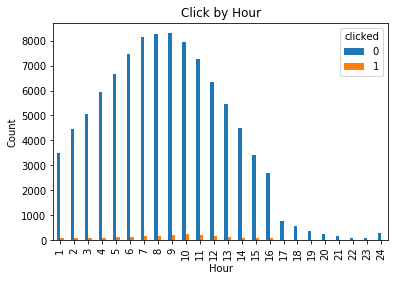

In [32]:
pd.crosstab(dataset.hour_UTC,dataset['clicked']).plot(kind='bar')
plt.title('Click by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')


Carry out the grouping based on the result of the chart above

In [33]:

def hour_grouping(dataset):
    if dataset['hour_UTC'] >= 1 and dataset['hour_UTC'] < 8:
        val = '1to7'
    elif dataset['hour_UTC'] >= 8 and dataset['hour_UTC'] < 13:
        val = '8to12'
    elif dataset['hour_UTC'] >= 13 and dataset['hour_UTC'] < 17:
        val = '13to16'
    else:
        val = '17beyond'
    return val

dataset['hour_grp'] = dataset.apply(hour_grouping, axis=1)


Generate dummy variables from the hour_grp variable

In [34]:
dmmy = pd.get_dummies(dataset['hour_grp']).rename(columns=lambda x: 'hour_grp_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

drop the hour_grp and hour variables as we no longer need them

In [35]:
dataset = dataset.drop('hour_grp', 1)
dataset = dataset.drop('hour', 1)


Plot the weekdays to see if I can observe a pattern. if there's no outstanding pattern we simply drop the variable

Text(0, 0.5, 'Count')

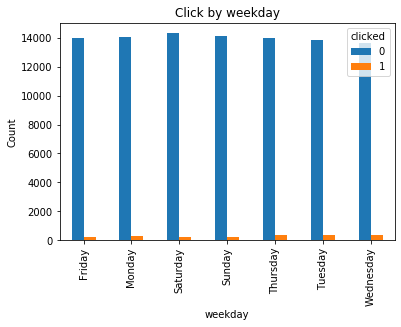

In [36]:
pd.crosstab(dataset.day_number2,dataset['clicked']).plot(kind='bar')
plt.title('Click by weekday')
plt.xlabel('weekday')
plt.ylabel('Count')

There's no outstanding pattern; hence, we can drop the variable.

Get the variables left in the dataset so as to identify the ones to drop

In [37]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 21 columns):
email_id                      100000 non-null int64
weekday                       100000 non-null object
user_past_purchases           100000 non-null int64
clicked                       100000 non-null int32
email_text_long_email         100000 non-null uint8
email_text_short_email        100000 non-null uint8
email_version_generic         100000 non-null uint8
email_version_personalized    100000 non-null uint8
user_country_ES               100000 non-null uint8
user_country_FR               100000 non-null uint8
user_country_UK               100000 non-null uint8
user_country_US               100000 non-null uint8
hour_UTC_init                 100000 non-null int64
day_number                    100000 non-null int64
newday                        100000 non-null int64
day_number2                   100000 non-null object
hour_UTC                      100000 non-null int64
hour

In [38]:
dataset = dataset.drop('weekday', 1)
dataset = dataset.drop('day_number2', 1)
dataset = dataset.drop('day_number', 1)
dataset = dataset.drop('newday', 1)
dataset = dataset.drop('hour_UTC', 1)
dataset = dataset.drop('hour_UTC_init', 1)
dataset = dataset.drop('email_id', 1)

I proceed to modelling 

check ratio of dependent variable

In [39]:
dataset['clicked'].value_counts()

0    97881
1     2119
Name: clicked, dtype: int64

We can see that there's an imbalance in the dependent variable, I shall resolve that later in the script

I create a correlation plot to identify pairs of independent variables that are higly correlated; hence, one half of each pair can be dropped 

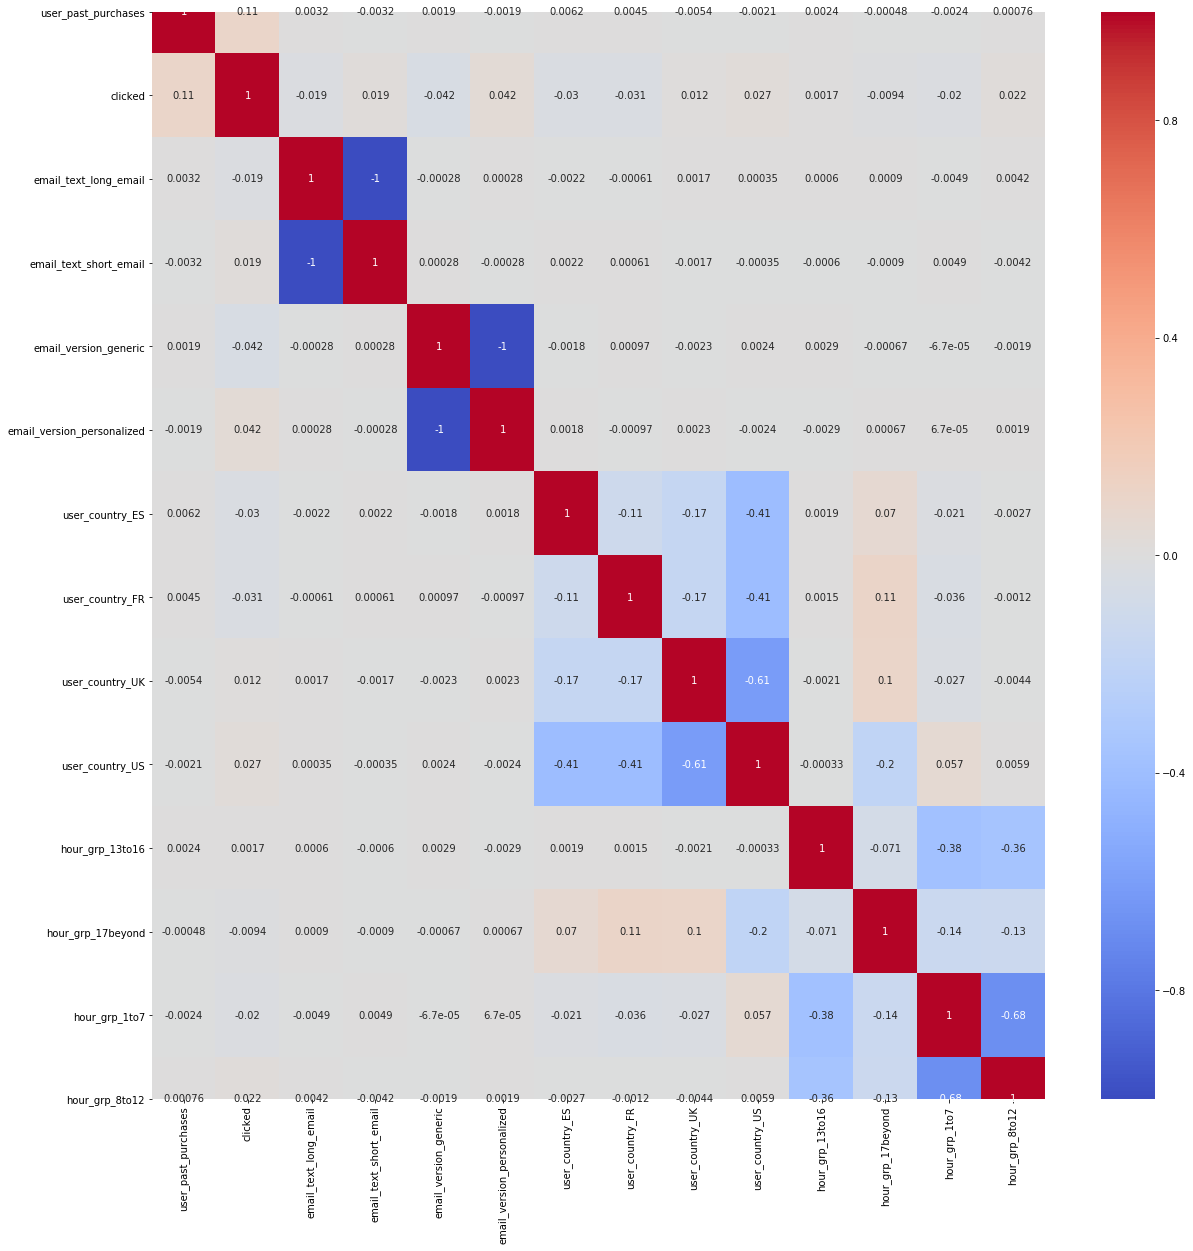

In [40]:
corr = dataset.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True);


email_text_long_email & email_text_long_email, email_version_generic & email_version_personalized are higly correlated so I'll drop email_text_long_email and email_version_generic

In [41]:
dataset = dataset.drop('email_text_long_email', 1)   
dataset = dataset.drop('email_version_generic', 1)  

split the dataset into train and test

In [42]:
from sklearn.model_selection import train_test_split

X = dataset.loc[:, dataset.columns != 'clicked']
y = dataset.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


To handle the imbalance identified earlier, I shall undersample the dataset

In [43]:
from imblearn.under_sampling import (RandomUnderSampler)
sampler = RandomUnderSampler(random_state=42)
X_rs, y_rs = sampler.fit_sample(X_train, y_train)

check the distribution of the dependent variable

In [44]:
y_rs.value_counts()

1    1589
0    1589
Name: clicked, dtype: int64

The dependent variable has equal frequency for both 0 and 1.

Scale the dataset

In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_rs_sc = sc.fit_transform(X_rs)
X_test_sc = sc.transform(X_test)


identify the significant variables. I have decided to identify 6 significant variables

In [46]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()


rfe = RFE(logreg, 6)
rfe = rfe.fit(X_rs_sc, y_rs.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True False False False False False  True]
[1 1 1 1 1 3 4 2 6 5 1]


The result above corresponds to the following variables: user_past_purchases,email_text_short_email,email_version_personalized,
user_country_ES, user_country_FR, hour_grp_8to12 

Charts shall be developed to show the impact of each of the variables


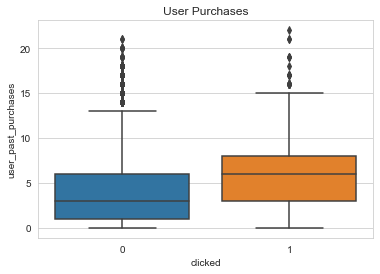

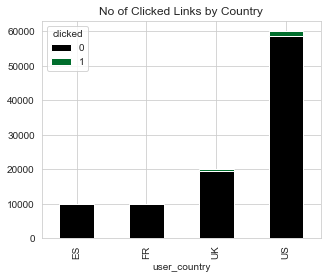

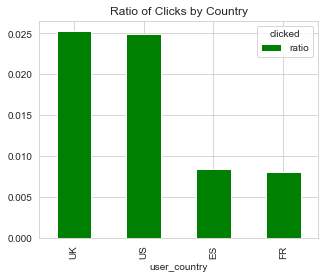

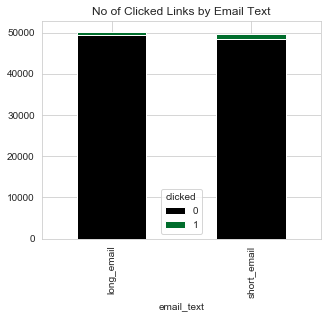

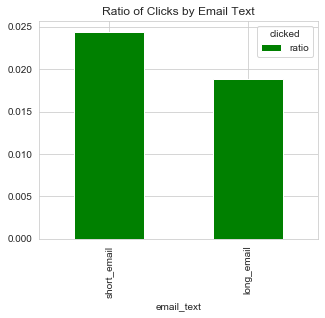

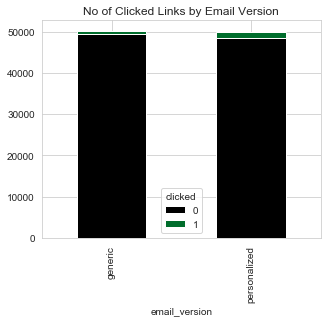

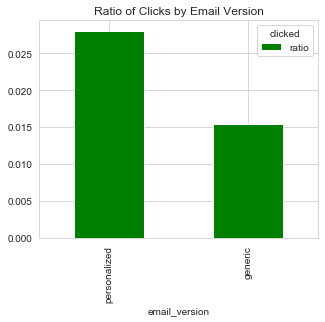

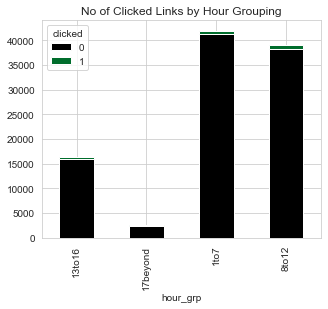

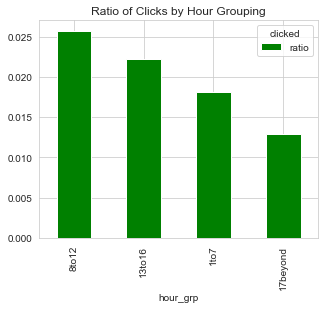

In [47]:
sns.set_style("whitegrid")
sns.boxplot('clicked', 'user_past_purchases', data=dataset2)
plt.xlabel('clicked') # Set text for the x axis
plt.ylabel('user_past_purchases')# Set text for y axis
plt.title('User Purchases')
plt.show()



user_country = dataset2.user_country.unique()

country_count = dataset2.groupby(['user_country','clicked']).count()[['email_id']]
country_count = country_count.unstack(level=1)
country_count.columns = country_count.columns.droplevel(level=0)

country_count['ratio'] = country_count[1]/country_count[0]


colors = ["black","#006D2C"]
country_count.loc[:,[0,1]].plot.bar(stacked=True, color=colors, figsize=(5,4), title ="No of Clicked Links by Country")
country_count.sort_values('ratio', ascending=False).loc[:,['ratio']].plot.bar(stacked=True, color='green', figsize=(5,4), title ="Ratio of Clicks by Country")



email_text = dataset2.email_text.unique()

email_text_count = dataset2.groupby(['email_text','clicked']).count()[['email_id']]
email_text_count = email_text_count.unstack(level=1)
email_text_count.columns = email_text_count.columns.droplevel(level=0)

email_text_count['ratio'] = email_text_count[1]/email_text_count[0]

colors = ["black","#006D2C"]
email_text_count.loc[:,[0,1]].plot.bar(stacked=True, color=colors, figsize=(5,4), title ="No of Clicked Links by Email Text")
email_text_count.sort_values('ratio', ascending=False).loc[:,['ratio']].plot.bar(stacked=True, color='green', figsize=(5,4), title ="Ratio of Clicks by Email Text")


email_version = dataset2.email_version.unique()

email_version_count = dataset2.groupby(['email_version','clicked']).count()[['email_id']]
email_version_count = email_version_count.unstack(level=1)
email_version_count.columns = email_version_count.columns.droplevel(level=0)

email_version_count['ratio'] = email_version_count[1]/email_version_count[0]

colors = ["black","#006D2C"]
email_version_count.loc[:,[0,1]].plot.bar(stacked=True, color=colors, figsize=(5,4), title ="No of Clicked Links by Email Version")
email_version_count.sort_values('ratio', ascending=False).loc[:,['ratio']].plot.bar(stacked=True, color='green', figsize=(5,4), title ="Ratio of Clicks by Email Version")

dataset2['hour_UTC_init'] = dataset2.apply(hour_UTC, axis=1)
dataset2['hour_UTC'] = dataset2.apply(hour_UTC_init, axis=1)
dataset2['hour_grp'] = dataset2.apply(hour_grouping, axis=1)


hour_grp = dataset2.hour_grp.unique()

hour_grp_count = dataset2.groupby(['hour_grp','clicked']).count()[['email_id']]
hour_grp_count = hour_grp_count.unstack(level=1)
hour_grp_count.columns = hour_grp_count.columns.droplevel(level=0)

hour_grp_count['ratio'] = hour_grp_count[1]/hour_grp_count[0]

colors = ["black","#006D2C"]
hour_grp_count.loc[:,[0,1]].plot.bar(stacked=True, color=colors, figsize=(5,4), title ="No of Clicked Links by Hour Grouping")
hour_grp_count.sort_values('ratio', ascending=False).loc[:,['ratio']].plot.bar(stacked=True, color='green', figsize=(5,4), title ="Ratio of Clicks by Hour Grouping")



#sns.set_style("whitegrid")
#sns.boxplot('clicked', 'user_past_purchases', data=dataset2)
#plt.xlabel('clicked') # Set text for the x axis
#plt.ylabel('user_past_purchases')# Set text for y axis
#plt.show()




From the charts of the significant variables we can answer two questions which are: optimizing the campaign to increase the probability of user clicks and identifying patterns with respect to how the email campaign performed.

The first variable deals with the number of purchases. The higher the number of purchases, the more likely the user is to click on the link this can be seen as the mean and upper quartile for users who responded positively is higher than that of those who responded negatively

The second variable tackled using the chart is the country of the user. From the first two charts, we see that users in UK and US are more likely to click on the link as compared to Spain and France

The third variable tackled using the chart is the email text. The charts relating to this variable indicate that users respond better to short emails than long emails. 

For the fourth variable tackled by the charts, we have the email version. Users are more likely to show a positive response when a personalized email is sent as shown in the ratios of both charts.

For the fifth variable tackled by the charts, we have the Hour Grouping. Users are more likely to show a positive response when a the mail is received between 8:00 and 12:00 hrs UTC.

Hence, in order to increase the probability of user clicks, I suggest sending short, personalized emails between 8:00 and 12:00 hrs UTC

In addition, from the analysis done; the pattern observed is that most users in the US and UK, who got a short, personalized email between 8:00 and 12:00 hrs UTC and have higher purchases responded positively

To calculate how much the model will improve the click through rate. I shall first run my model against the test dataset

In [48]:
logreg = LogisticRegression()
logreg.fit(X_rs_sc[:,[0,1,2,3,4,9]], y_rs)
#logreg.fit(X_rs_sc, y_rs)

y_pred_lr2 = logreg.predict(X_test_sc[:,[0,1,2,3,4,10]])#[:,[0,2,3,4]])

print(classification_report(y_test,y_pred_lr2))

              precision    recall  f1-score   support

           0       0.99      0.68      0.80     24470
           1       0.04      0.64      0.08       530

    accuracy                           0.67     25000
   macro avg       0.51      0.66      0.44     25000
weighted avg       0.97      0.67      0.79     25000



To build on the above result I would pick out the users who did not click on the link and change the email_text to short_email, email_version to personalized and the hour_grouping variable to between 8:00 to 12:00 hr

In [49]:
is_clicked =  dataset_bckup['clicked']==0
dataset_0clicked = dataset_bckup[is_clicked]


Change the email_text to 'short_email' and email_version to 'personalized'

In [50]:
dataset_0clicked = dataset_0clicked.assign(email_text='short_email')
dataset_0clicked = dataset_0clicked.assign(email_version='personalized')

Set dummy variables for email_text, email_version and country

In [51]:
dmmy = pd.get_dummies(dataset_0clicked['email_text']).rename(columns=lambda x: 'email_text_' + str(x))
dataset_0clicked = pd.concat([dataset_0clicked,dmmy],axis = 1)

dmmy = pd.get_dummies(dataset_0clicked['email_version']).rename(columns=lambda x: 'email_version_' + str(x))
dataset_0clicked = pd.concat([dataset_0clicked,dmmy],axis = 1)

dmmy = pd.get_dummies(dataset_0clicked['user_country']).rename(columns=lambda x: 'user_country_' + str(x))
dataset_0clicked = pd.concat([dataset_0clicked,dmmy],axis = 1)


Convert the Hr column to UTC and create dummy variables

In [52]:
dataset_0clicked['hour_UTC_init'] = dataset_0clicked.apply(hour_UTC, axis=1)
dataset_0clicked['hour_UTC_init'].unique()

dataset_0clicked['hour_UTC'] = dataset_0clicked.apply(hour_UTC_init, axis=1)
dataset_0clicked['hour_UTC'].unique()

dataset_0clicked['hour_grp'] = dataset_0clicked.apply(hour_grouping, axis=1)

dmmy = pd.get_dummies(dataset_0clicked['hour_grp']).rename(columns=lambda x: 'hour_grp_' + str(x))
dataset_0clicked = pd.concat([dataset_0clicked,dmmy],axis = 1)


Set hour_grp_8to12 to 1 and set the other hr_grp to 0

In [53]:
dataset_0clicked = dataset_0clicked.assign(hour_grp_13to16 = 0)
dataset_0clicked = dataset_0clicked.assign(hour_grp_1to7 = 0)
dataset_0clicked = dataset_0clicked.assign(hour_grp_17beyond = 0)
dataset_0clicked = dataset_0clicked.assign(hour_grp_8to12 = 1)

drop variables not needed (this would include clicked variable as we are going to use this dataframe for prediction)

In [54]:
dataset_0clicked = dataset_0clicked.drop('email_text', 1)
dataset_0clicked = dataset_0clicked.drop('user_country', 1)
dataset_0clicked = dataset_0clicked.drop('email_version', 1)
dataset_0clicked = dataset_0clicked.drop('hour_UTC_init', 1)
dataset_0clicked = dataset_0clicked.drop('hour_UTC', 1)
dataset_0clicked = dataset_0clicked.drop('email_id', 1)
dataset_0clicked = dataset_0clicked.drop('hour', 1)
dataset_0clicked = dataset_0clicked.drop('weekday', 1)
dataset_0clicked = dataset_0clicked.drop('hour_grp', 1)
dataset_0clicked = dataset_0clicked.drop('clicked', 1)

scale the dataframe

In [55]:
dataset_0clicked_sc = sc.fit_transform(dataset_0clicked)

Predict on the dataset and get the count of positive predictions

In [56]:
testpred = logreg.predict(dataset_0clicked_sc[:,[0,1,2,3,4,10]])#[:,[0,2,3,4]])
print("Number of users that responded postively "+ str(np.count_nonzero(testpred == 1)) )
print("Click through rate "+ str(round(np.count_nonzero(testpred == 1)/len(testpred) * 100,2)) + "%")


Number of users that responded postively 39695
Click through rate 40.55%


As we can see the percentage has gone up from the value gotten previously i.e 10.35%